## Introduction
In this notebook we will create a custom DataSet which will load and return an X-Ray image together with the location of the heart

## Imports:

* Path for easy path handling
* torch for dataset creation
* numpy for loading the images
* pandas for loading the csv file containing the labels
* imgaug to set a random seed for augmentations
* BoundingBox from imgaug to automatically handle the coordinates when augmenting the image



In [3]:
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox
from pathlib import Path

In [4]:
import os
import cv2

In [5]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [14]:
df = pd.read_csv('Data/train_df.csv')

In [15]:
df.head()

,image_id,num_potholes,x,y,w,h
0,G0010033,6,1990,1406,66,14
1,G0010033,6,1464,1442,92,16
2,G0010033,6,1108,1450,54,16
3,G0010033,6,558,1434,102,16
4,G0010033,6,338,1450,72,18


In [19]:
df.image_id.nunique()

3940

In [17]:
directory = 'Data\Dataset\Train data\\Negative Data'
        
# iterate over files in that directory
for root, dirs, files in os.walk(directory):
    # print(root)
    for filename in files:
        name = filename.replace('.',' ').split()[0]
        df = df.append()

## DataSet Creation
Now we define the torch dataset!
We need to define a __ len __ function which returns the length of the dataset and a __ getitem __ function which returns the image and corresponding bounding box.

Additionally we apply data augmentation and normalization.

**Important**: Augment bounding box together with image!<br />
You can use *BoundingBox(x1, y1, x2, y2) for that*.<br />
Next you call *self.augment(image=img, bounding_boxes=bb)* which returns the augmented image and bounding boxes<br />
Finally you extract the coordinates from the augmented bbox coordinates. Note that it is a 2D array.
```python
bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
```

In [6]:
# First create the augmentation object

seq = iaa.Sequential([
            iaa.Affine(
                scale=(0.75),
                rotate=(-10, 10),
                translate_px=(-10, 10)
            )
        ])

In [7]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, directory,root, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        self.bbox = []
        self.root_path = root
        self.directory = directory
        self.patients = []
        self.augment = augs

    def set_up_dataset(self):
        for root, dirs, files in os.walk(self.directory):
            for filename in files:
                path = os.path.join(root, filename)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                y, x = img.shape
                img = cv2.resize(img,(720,720))
                patient = filename.replace('.',' ').split()[0]
                data = self.labels[self.labels["image_id"]==patient]
        
                # Get entries of given patient
                # Extract coordinates
                x_min = data["x"]*(720/x)
                y_min = data["y"]*(720/y)
                x_max = x_min + data["w"]*(720/x)  # get xmax from width
                y_max = y_min + data["h"]*(720/y)  # get ymax from height
                try:
                    max_arg = y_max.argmax()
                    bbox = [x_min.to_list()[max_arg],y_min.to_list()[max_arg],x_max.to_list()[max_arg],y_max.to_list()[max_arg]]
                except:
                    max_arg = 0
                    bbox = [np.NaN, np.NaN, np.NaN, np.NaN]
                
                self.patients.append(img)
                self.bbox.append(bbox)
                
    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)
        
    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        bbox = self.bbox[idx]

        # # Load file and convert to float32
        # file_path = self.root_path/patient  # Create the path to the file
        # img = np.load(f"{file_path}.npy").astype(np.float32)
        img = patient.astype(np.float32)
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            ###################IMPORTANT###################
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            # https://github.com/pytorch/pytorch/issues/5059
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            #####################################################

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
            
        # Normalize the image according to the values computed in Preprocessing
        img = (img - 0.494) / 0.252

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
            
        return img, bbox


In [8]:
labels_path = "Data/train_df.csv"
patients_path = "Data/Dataset/Train data/"
train_root = "Processed/train/"
dataset = CardiacDataset("Data/train_df.csv",'Data/Dataset/Test data',train_root,None)

In [9]:
dataset.set_up_dataset()

In [10]:
len(dataset)

628

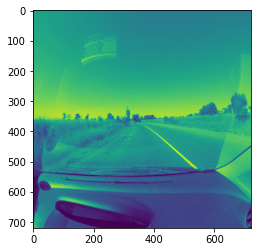

In [13]:
img , bbox = dataset[300]
fig, axis = plt.subplots(1, 1)
axis.imshow(img[0])
# print(num)
# if num != 0:
# for i in range(len(bbox[0])):
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

Awesome! Now we can move to training the heart detection network

In [ ]:
type(img[0][0][0].item())

float